#**02_TERM FREQUENCY AND TFIDF**

Summary:


1.   Load Back Data and Merging
2.   Split *narco_data* into Schedules ([DEA](https://www.dea.gov/drug-information/drug-scheduling))
3.   Term Frequency
4.   TfIdf on Schedule 1 and Schedule 2
5.   TfIdf with respect to Time Periods

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Università/inforet_prj/')

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import pickle
import spacy
import string
#import seaborn as sns; sns.set()
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

## **1. Load Back Data and Merging**

In [ ]:
narco_nlp = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_nlp.csv", sep="|", names=["spacy_nlp"])
narco_nlp

,spacy_nlp
0,was be AUX; indicted indict VERB; counts count...
1,was be AUX; convicted convict VERB; following ...
2,issue issue NOUN; these these DET; consolidate...
3,subject subject NOUN; appeal appeal NOUN; is b...
4,much much ADV; publicized publicize VERB; jury...
...,...
11048,granted grant VERB; motion motion NOUN; dismis...
11049,jury jury NOUN; trial trial NOUN; defendant de...
11050,testified testify VERB; that that SCONJ; drank...
11051,was be AUX; charged charge VERB; indictment in...


In [ ]:
narco_df = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_df.csv", sep="|")
narco_df

,type,text,author,id,year
0,majority,CHIEF JUSTICE HEIPLE\ndelivered the opinion of...,CHIEF JUSTICE HEIPLE,1,1997
1,majority,JUSTICE HARRISON\ndelivered the opinion of the...,JUSTICE HARRISON,2,1997
2,majority,JUSTICE BILANDIC\ndelivered the opinion of the...,JUSTICE BILANDIC,5,1997
3,majority,JUSTICE ZWICK\ndelivered the opinion of the co...,JUSTICE ZWICK,8,1997
4,majority,JUSTICE WELCH\ndelivered the opinion of the co...,JUSTICE WELCH,11,1997
...,...,...,...,...,...
11048,majority,Mr. PRESIDING JUSTICE GOLDBERG\ndelivered the ...,Mr. PRESIDING JUSTICE GOLDBERG,183108,1976
11049,majority,PRESIDING JUSTICE QUINN\ndelivered the opinion...,PRESIDING JUSTICE QUINN,183124,2006
11050,majority,MR. JUSTICE ENGLISH\ndelivered the opinion of ...,MR. JUSTICE ENGLISH,183126,1965
11051,majority,JUSTICE LaPORTA\ndelivered the opinion of the ...,JUSTICE LaPORTA,183138,1991


In [ ]:
# Convert back the original string from the form
#   text lemma POS; text lemma POS; text lemma POS; ...

def convert_nlp_to_list(row):
    if "; " not in row:
        return row.split()
    else:
        return [triplet.split() for triplet in row.split("; ")]

In [ ]:
narco_nlp.spacy_nlp = narco_nlp.spacy_nlp.fillna("")

In [ ]:
narco_nlp.spacy_nlp = narco_nlp.spacy_nlp.progress_apply(lambda row: convert_nlp_to_list(row))

100%|██████████| 11053/11053 [00:30<00:00, 367.16it/s]


In [ ]:
narco_data = pd.concat([narco_df, narco_nlp], axis=1)

In [ ]:
del narco_df
del narco_nlp

In [ ]:
import gc
gc.collect()

147

In [ ]:
def get_element_triplet(row, position=0, as_string=True):
    # Position = 0: extract token
    # Position = 1: extract lemma
    # Position = 2: extract POS
    # as_string = True: joined string; False: list.

    elem_list = [triplet[position] for triplet in row]

    if as_string:
        return " ".join(elem_list)
    else:
        return elem_list

In [ ]:
# Text cleaned, tokens
text_cleaned = narco_data.spacy_nlp.progress_apply(lambda row: get_element_triplet(row, position=0, as_string=True))

In [ ]:
# List of POS
all_pos = narco_data.spacy_nlp.progress_apply(lambda row: get_element_triplet(row, position=2, as_string=False))

In [ ]:
# Lemmatized data # 45 min
narco_data['lemmatized'] = narco_data.spacy_nlp.progress_apply(lambda row: " ".join([y.lemma_ for y in nlp(get_element_triplet(row, position=1, as_string=True)) if not y.is_stop]))

100%|██████████| 11053/11053 [47:49<00:00,  3.85it/s]


In [ ]:
def typo(text):
    cleaned_text = (
        text.replace('cannabi ','cannabis ')
        )
    return cleaned_text

In [ ]:
narco_data['lemmatized'] = narco_data.lemmatized.progress_apply(lambda x: typo(x))
#typo(narco_data.lemmatized[30])

100%|██████████| 11053/11053 [00:00<00:00, 62787.40it/s]


### *1.1 Serialize narco_data*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "wb") as f:
    pickle.dump(narco_data, f)

---

## **2. Split *narco_data* into Schedules**

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "rb") as f:
  narco_data = pickle.load(f)

In [ ]:
schedule_1 = ["cannabis",  "marijuana", "mdma", "lsd", "heroin"] #https://www.dea.gov/drug-information/drug-scheduling
schedule_2 = ["cocaine", "methamphetamine", "fentanyl"]
schedule_3 = ["ketamine", "anabolic" , "steroids",  "testosterone"]
schedule_4 = ["modafinil", "provigil", "adderall", "methylphenidate", "memantine", "axura"] #SMART DRUGS 

In [ ]:
conditions = [
    (narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1)))
    ]

# create a list of the values we want to assign for each condition
values = ['narco_1', 'narco_2', 'narco_3', 'narco_4']

# create a new column and use np.select to assign values to it using our lists as arguments
narco_data['schedule'] = np.select(conditions, values)

# display updated DataFrame
narco_data.head()

,type,text,author,id,year,spacy_nlp,lemmatized,schedule
0,majority,CHIEF JUSTICE HEIPLE\ndelivered the opinion of...,CHIEF JUSTICE HEIPLE,1,1997,"[[was, be, AUX], [indicted, indict, VERB], [co...",indict count murder aggravate criminal sexual ...,narco_2
1,majority,JUSTICE HARRISON\ndelivered the opinion of the...,JUSTICE HARRISON,2,1997,"[[was, be, AUX], [convicted, convict, VERB], [...",convict follow jury trial degree murder aggrav...,0
2,majority,JUSTICE BILANDIC\ndelivered the opinion of the...,JUSTICE BILANDIC,5,1997,"[[issue, issue, NOUN], [these, these, DET], [c...",issue consolidated appeal constitutionality en...,narco_1
3,majority,JUSTICE ZWICK\ndelivered the opinion of the co...,JUSTICE ZWICK,8,1997,"[[subject, subject, NOUN], [appeal, appeal, NO...",subject appeal interlocutory order enter juven...,0
4,majority,JUSTICE WELCH\ndelivered the opinion of the co...,JUSTICE WELCH,11,1997,"[[much, much, ADV], [publicized, publicize, VE...",publicize jury trial defendant convict degree ...,0


Take here data if you want to analyze differences between years.

In [ ]:
narco_sch = narco_data.drop(['type','text','author', 'id','year','spacy_nlp'], axis = 1)

In [ ]:
# NARCO SCHEDULE MERGE
# Merge in one row all the opinions in the same schedule.
# We obtain narco_schedule with shape 5,2:
#   _0 (miscellaneous), narco_1, narco_2, narco_3, narco_4;
#   _schedule label and lemmatized corpora.

narco_schedule = narco_sch.groupby('schedule', as_index=False).agg({'lemmatized' : ' '.join})  

In [ ]:
narco_schedule

,schedule,lemmatized
0,0,convict follow jury trial degree murder aggrav...
1,narco_1,issue consolidated appeal constitutionality en...
2,narco_2,indict count murder aggravate criminal sexual ...
3,narco_3,appeal jury verdict find sexually violent pers...
4,narco_4,charge information count bribery count possess...


### *2.1 Serialize narco_schedule*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_schedule.pkl", "wb") as f:
    pickle.dump(narco_schedule, f)

---

## **3. Term Frequency**

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_schedule.pkl", "rb") as f:
  narco_schedule = pickle.load(f)

In [ ]:
# Divide 
# narco_schedule.loc[narco_schedule.schedule == "0"] #7341 
narco_schedule_1 = narco_schedule.loc[narco_schedule['schedule']=="narco_1"] # 1741  
narco_schedule_2 = narco_schedule.loc[narco_schedule['schedule']=="narco_2"] # 1957 
narco_schedule_3 = narco_schedule.loc[narco_schedule['schedule']=="narco_3"] # 12
narco_schedule_4 = narco_schedule.loc[narco_schedule['schedule']=="narco_4"] # 2

In [ ]:
nar = narco_schedule[(narco_schedule.schedule == 'narco_1') | (narco_schedule.schedule =='narco_2')]

In [ ]:
vectorizer = CountVectorizer()
vector_narco = vectorizer.fit_transform(nar['lemmatized'])
words_list = vectorizer.get_feature_names()
count_list = vector_narco.toarray().sum(axis=0)
w = dict(zip(words_list, count_list))
w = {k: v for k, v in sorted(w.items(), key=lambda item: item[1], reverse=True)}
mcw = pd.DataFrame.from_dict(w, orient='index').reset_index()
mcw.columns = ["words_tot", "abs_freq"]
mcw["rel_freq"] = mcw.progress_apply(lambda x: np.round(x.abs_freq / mcw.abs_freq.sum(), 3), axis=1)
mcw[:50]

100%|██████████| 21322/21322 [00:02<00:00, 7385.42it/s]


,words_tot,abs_freq,rel_freq
0,defendant,183273,0.044
1,trial,69849,0.017
2,evidence,47004,0.011
3,find,34021,0.008
4,testify,32738,0.008
5,officer,28546,0.007
6,police,26681,0.006
7,testimony,23251,0.006
8,state,22752,0.005
9,jury,21743,0.005


In [ ]:
vectorizer = CountVectorizer()
#words_list = vectorizer.get_feature_names()
#
X = vectorizer.fit_transform(narco_schedule_1['lemmatized'])
words_list_1 = vectorizer.get_feature_names()
count_list_1 = X.toarray().sum(axis=0)
w_1 = dict(zip(words_list_1, count_list_1))
w_1 = {k: v for k, v in sorted(w_1.items(), key=lambda item: item[1], reverse=True)}
mcw_1 = pd.DataFrame.from_dict(w_1, orient='index').reset_index()
mcw_1.columns = ["words_1", "abs_freq"]
mcw_1["rel_freq"] = mcw_1.progress_apply(lambda x: np.round(x.abs_freq / mcw_1.abs_freq.sum(), 3), axis=1)
mcw_1["log_freq"] = mcw_1.progress_apply(lambda x: np.round(1+(math.log(x.abs_freq,5)), 3), axis=1)
mcw_1["augm_freq"] = mcw_1.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw_1.abs_freq.max()), 3), axis=1)
#
Y = vectorizer.fit_transform(narco_schedule_2['lemmatized'])
words_list_2 = vectorizer.get_feature_names()
count_list_2 = Y.toarray().sum(axis=0)
w_2 = dict(zip(words_list_2, count_list_2))
w_2 = {k: v for k, v in sorted(w_2.items(), key=lambda item: item[1], reverse=True)}
mcw_2 = pd.DataFrame.from_dict(w_2, orient='index').reset_index()
mcw_2.columns = ["words_2", "abs_freq"]
mcw_2["rel_freq"] = mcw_2.progress_apply(lambda x: np.round(x.abs_freq / mcw_2.abs_freq.sum(), 3), axis=1)
mcw_2["log_freq"] = mcw_2.progress_apply(lambda x: np.round(1+(math.log(x.abs_freq,5)), 3), axis=1)
mcw_2["augm_freq"] = mcw_2.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw_2.abs_freq.max()), 3), axis=1)

100%|██████████| 17675/17675 [00:01<00:00, 9984.88it/s] 


In [ ]:
mcw_1_2_concat = pd.concat([mcw_1[:20],mcw_2[:20]], axis=1)
mcw_1_2_concat # WORDS = tinfou, mitte, wtappe

,words_1,abs_freq,rel_freq,log_freq,augm_freq,words_2,abs_freq,rel_freq,log_freq,augm_freq
0,defendant,68768,0.043,7.921,1.000,defendant,114505,0.045,8.238,1.000
1,trial,25496,0.016,7.304,0.685,trial,44353,0.017,7.648,0.694
2,evidence,17607,0.011,7.074,0.628,evidence,29397,0.011,7.393,0.628
3,find,13156,0.008,6.893,0.596,find,20865,0.008,7.180,0.591
4,testify,12590,0.008,6.866,0.592,testify,20148,0.008,7.158,0.588
5,officer,12287,0.008,6.851,0.589,police,16328,0.006,7.027,0.571
6,police,10353,0.006,6.744,0.575,officer,16259,0.006,7.025,0.571
7,testimony,9796,0.006,6.710,0.571,state,14193,0.006,6.940,0.562
8,search,9316,0.006,6.679,0.568,jury,14138,0.006,6.938,0.562
9,arrest,8614,0.005,6.630,0.563,testimony,13455,0.005,6.907,0.559


In [ ]:
common_terms = list(set(mcw_1["words_1"][:10].values).intersection(set(mcw_2["words_2"][:200].values)))
common_terms

['search',
 'testimony',
 'trial',
 'find',
 'police',
 'arrest',
 'evidence',
 'testify',
 'officer',
 'defendant']

In [ ]:
# COMMON
a = mcw.words_tot[:50]
b = mcw_1.words_1[:50]
c = mcw_2.words_2[:50]
ab = pd.DataFrame([ element for element in a if element in b], columns = ['tot_narco1'])
ac = pd.DataFrame([ element for element in a if element in c], columns = ['tot_narco2'])
bc = pd.DataFrame([ element for element in b if element in c], columns = ['narco1_narco2'])
#x = pd.concat([ab, ac,bc],axis=1 ) 
bc

,narco1_narco2


In [ ]:
df_top50 = pd.concat([a, b, c],axis=1) ## MOLTO STRANO!!
df_top50[:10]

,words_tot,words_1,words_2
0,defendant,defendant,defendant
1,trial,trial,trial
2,evidence,evidence,evidence
3,find,find,find
4,testify,testify,testify
5,officer,officer,police
6,police,police,officer
7,testimony,testimony,state
8,state,search,jury
9,jury,arrest,testimony


In [ ]:
# NOT COMMON ## NON FUNZIONA?!
a = mcw.words_tot[:30]
b = mcw_1.words_1[:30]
c = mcw_2.words_2[:30]
ab = pd.DataFrame([ element for element in a if element not in b], columns = ['tot_narco1'])
ac = pd.DataFrame([ element for element in a if element not in c], columns = ['tot_narco2'])
bc = pd.DataFrame([ element for element in b if element not in c], columns = ['narco1_narco2'])
x = pd.concat([ab, ac,bc], axis=1 ) 
x

,tot_narco1,tot_narco2,narco1_narco2
0,defendant,defendant,defendant
1,trial,trial,trial
2,evidence,evidence,evidence
3,find,find,find
4,testify,testify,testify
5,officer,officer,officer
6,police,police,police
7,testimony,testimony,testimony
8,state,state,search
9,jury,jury,arrest


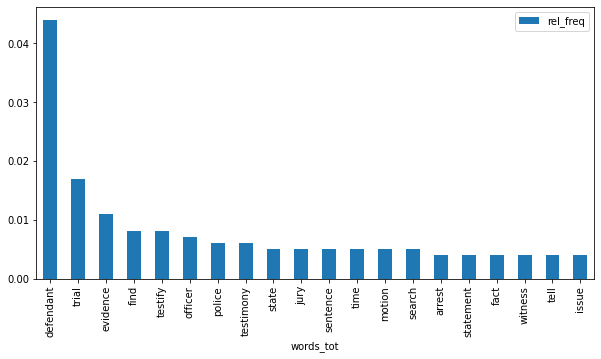

In [ ]:
mcw[:20].plot(x="words_tot", y="rel_freq", kind="bar", figsize=(10,5)) 
plt.show()

In [ ]:
mcw["augm_freq"] = mcw.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw.abs_freq.max()), 3), axis=1)

100%|██████████| 21322/21322 [00:02<00:00, 9487.37it/s] 


Text(0, 0.5, 'Augemnted Frequency')

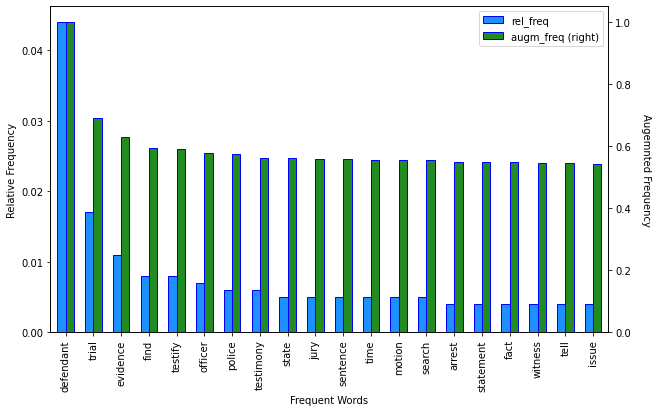

In [ ]:
mcw_freqs = mcw[['words_tot','rel_freq','augm_freq']]
ax = mcw_freqs[:20].plot(kind='bar', x = 'words_tot', secondary_y = 'augm_freq', color={"rel_freq": "dodgerblue", "augm_freq": "forestgreen"}, edgecolor='blue', figsize=(10,6), width= 0.6)

ax.set_xlabel("Frequent Words")
ax.set_ylabel("Relative Frequency")
plt.ylabel('Augemnted Frequency', rotation=-90, labelpad=20)

---

## **4. TfIdf on Schedule 1 and Schedule 2**

In [ ]:
narco_schedule

,schedule,lemmatized
0,0,convict follow jury trial degree murder aggrav...
1,narco_1,issue consolidated appeal constitutionality en...
2,narco_2,indict count murder aggravate criminal sexual ...
3,narco_3,appeal jury verdict find sexually violent pers...
4,narco_4,charge information count bribery count possess...


In [ ]:
nar = narco_schedule[(narco_schedule.schedule == 'narco_1') | (narco_schedule.schedule =='narco_2')]

In [ ]:
nar

,schedule,lemmatized
1,narco_1,issue consolidated appeal constitutionality en...
2,narco_2,indict count murder aggravate criminal sexual ...


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(nar['lemmatized'])
tfidf_1 = tfidf_vectorizer.transform(narco_schedule_1['lemmatized'])
tfidf_2 = tfidf_vectorizer.transform(narco_schedule_2['lemmatized'])
feature_names=tfidf_vectorizer.get_feature_names()
items_1=sort_coo(tfidf_1.tocoo())
items_2=sort_coo(tfidf_2.tocoo())
keyw_1=extract_topn_from_vector(feature_names,items_1,30)
keyw_2=extract_topn_from_vector(feature_names,items_2,30)
keyw_1 = pd.DataFrame(list(keyw_1.items()),columns = ['word_1','tfidf_1'])
keyw_2 = pd.DataFrame(list(keyw_2.items()),columns = ['word_2','tfidf_2']) 
tfidf_schedule_drugs = pd.concat([keyw_1, keyw_2], axis=1)
tfidf_schedule_drugs

,word_1,tfidf_1,word_2,tfidf_2
0,defendant,0.713,defendant,0.727
1,trial,0.264,trial,0.282
2,evidence,0.182,evidence,0.187
3,find,0.136,find,0.132
4,testify,0.130,testify,0.128
5,officer,0.127,police,0.104
6,police,0.107,cocaine,0.104
7,testimony,0.102,officer,0.103
8,search,0.097,state,0.090
9,arrest,0.089,jury,0.090


In [ ]:
#int_df = pd.merge(keyw_1, keyw_2, how ='inner', on =['word', 'word'])
#print(int_df)

In [ ]:
pd.DataFrame([ element for element in keyw_1.word_1[:20] if element not in keyw_2.word_2[:20]], columns = ['tot_narco1']) ## NON FUNZIONA!!

,tot_narco1
0,defendant
1,trial
2,evidence
3,find
4,testify
5,officer
6,police
7,testimony
8,search
9,arrest


---

## **5. TfIdf with respect to Time Periods**

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "rb") as f:
  narco_data = pickle.load(f)

In [ ]:
schedule_1 = ["cannabis",  "marijuana", "mdma", "lsd", "heroin"] #https://www.dea.gov/drug-information/drug-scheduling
schedule_2 = ["cocaine", "methamphetamine", "fentanyl"]
schedule_3 = ["ketamine", "anabolic" , "steroids",  "testosterone"]
schedule_4 = ["modafinil", "provigil", "adderall", "methylphenidate", "memantine", "axura"] #SMART DRUGS 

#### 5.1 **Schedule 1**: *narco_1_time* building

In [ ]:
narco_data_1 = narco_data[(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4)))] # 1741 

In [ ]:
narco_1_time = narco_data_1.drop(['type','text','author', 'id','spacy_nlp'], axis = 1)

In [ ]:
#narco_1_time['year'].astype(str).astype(int)

In [ ]:
narco_1_time.loc[(narco_1_time["year"] >= 1950) & (narco_1_time["year"] <= 1959), 'year'] = 50 # 33
narco_1_time.loc[(narco_1_time["year"] >= 1960) & (narco_1_time["year"] <= 1969), 'year'] = 60 # 222
narco_1_time.loc[(narco_1_time["year"] >= 1970) & (narco_1_time["year"] <= 1979), 'year'] = 70 # 560
narco_1_time.loc[(narco_1_time["year"] >= 1980) & (narco_1_time["year"] <= 1989), 'year'] = 80 # 414
narco_1_time.loc[(narco_1_time["year"] >= 1990) & (narco_1_time["year"] <= 1999), 'year'] = 90 # 251
narco_1_time.loc[(narco_1_time["year"] >= 2000) & (narco_1_time["year"] <= 2009), 'year'] = 10 # 229

In [ ]:
narco_1_time.loc[narco_1_time["year"] == 50, 'year'] = '50s' 
narco_1_time.loc[narco_1_time["year"] == 60, 'year'] = '60s' 
narco_1_time.loc[narco_1_time["year"] == 70, 'year'] = '70s' 
narco_1_time.loc[narco_1_time["year"] == 80, 'year'] = '80s' 
narco_1_time.loc[narco_1_time["year"] == 90, 'year'] = '90s'
narco_1_time.loc[narco_1_time["year"] == 10, 'year'] = '00s'

In [ ]:
narco_1_time.loc[narco_1_time.year == '00s'].shape

(213, 2)

In [ ]:
narco_1_time.drop(narco_1_time.loc[(narco_1_time["year"] != '50s' ) & (narco_1_time["year"] != '60s') & (narco_1_time["year"] != '70s') & (narco_1_time["year"] != '80s') & (narco_1_time["year"] != '90s') & (narco_1_time["year"] != '00s')].index, inplace=True)

In [ ]:
narco_1_time = narco_1_time.groupby('year', as_index=False).agg({'lemmatized' : ' '.join})  

In [ ]:
narco_1_50s = narco_1_time.loc[narco_1_time['year']=="50s"] # 2507  
narco_1_60s = narco_1_time.loc[narco_1_time['year']=="60s"] 
narco_1_70s = narco_1_time.loc[narco_1_time['year']=="70s"]
narco_1_80s = narco_1_time.loc[narco_1_time['year']=="80s"]
narco_1_90s = narco_1_time.loc[narco_1_time['year']=="90s"]
narco_1_00s = narco_1_time.loc[narco_1_time['year']=="00s"]

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_1_time.pkl", "wb") as f:
    pickle.dump(narco_1_time, f)

#### 5.2 **Schedule 1**: TfIdf *narco_1_time*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_1_time.pkl", "rb") as f:
  narco_1_time = pickle.load(f)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(narco_1_time['lemmatized'])
tfidf_50_59 = tfidf_vectorizer.transform(narco_1_50s['lemmatized'])
tfidf_60_69 = tfidf_vectorizer.transform(narco_1_60s['lemmatized'])
tfidf_70_79 = tfidf_vectorizer.transform(narco_1_70s['lemmatized'])
tfidf_80_89 = tfidf_vectorizer.transform(narco_1_80s['lemmatized'])
tfidf_90_99 = tfidf_vectorizer.transform(narco_1_90s['lemmatized'])
tfidf_00_09 = tfidf_vectorizer.transform(narco_1_00s['lemmatized'])
feature_names=tfidf_vectorizer.get_feature_names()
items_50_59=sort_coo(tfidf_50_59.tocoo())
items_60_69=sort_coo(tfidf_60_69.tocoo())
items_70_79=sort_coo(tfidf_70_79.tocoo())
items_80_89=sort_coo(tfidf_80_89.tocoo())
items_90_99=sort_coo(tfidf_90_99.tocoo())
items_00_09=sort_coo(tfidf_00_09.tocoo())
keyw_50_59=extract_topn_from_vector(feature_names,items_50_59,30)
keyw_60_69=extract_topn_from_vector(feature_names,items_60_69,30)
keyw_70_79=extract_topn_from_vector(feature_names,items_70_79,30)
keyw_80_89=extract_topn_from_vector(feature_names,items_80_89,30)
keyw_90_99=extract_topn_from_vector(feature_names,items_90_99,30)
keyw_00_09=extract_topn_from_vector(feature_names,items_00_09,30)
keyw_50_59 = pd.DataFrame(list(keyw_50_59.items()),columns = ['word_50','tfidf'])
keyw_60_69 = pd.DataFrame(list(keyw_60_69.items()),columns = ['word_60','tfidf']) 
keyw_70_79 = pd.DataFrame(list(keyw_70_79.items()),columns = ['word_70','tfidf']) 
keyw_80_89 = pd.DataFrame(list(keyw_80_89.items()),columns = ['word_80','tfidf']) 
keyw_90_99 = pd.DataFrame(list(keyw_90_99.items()),columns = ['word_90','tfidf']) 
keyw_00_09 = pd.DataFrame(list(keyw_00_09.items()),columns = ['word_95','tfidf'])

In [ ]:
tfidf_years = pd.concat([keyw_50_59, keyw_60_69, keyw_70_79, keyw_80_89, keyw_90_99, keyw_00_09], axis=1)
tfidf_years

,word_50,tfidf,word_60,tfidf,word_70,tfidf,word_80,tfidf,word_90,tfidf,word_95,tfidf
0,defendant,0.572,defendant,0.658,defendant,0.692,defendant,0.716,defendant,0.722,defendant,0.712
1,evidence,0.215,narcotic,0.275,trial,0.251,trial,0.270,trial,0.274,trial,0.273
2,officer,0.203,officer,0.189,evidence,0.176,evidence,0.175,evidence,0.188,evidence,0.183
3,narcotic,0.189,trial,0.181,officer,0.139,find,0.132,find,0.137,find,0.135
4,witness,0.170,evidence,0.173,find,0.131,testify,0.123,testify,0.126,testify,0.116
5,trial,0.164,testify,0.171,search,0.128,police,0.115,officer,0.108,officer,0.114
6,testify,0.163,testimony,0.149,testify,0.127,officer,0.110,police,0.096,police,0.102
7,error,0.160,arrest,0.145,testimony,0.114,testimony,0.103,testimony,0.093,motion,0.087
8,testimony,0.147,informer,0.144,police,0.110,arrest,0.098,search,0.089,time,0.084
9,arrest,0.147,find,0.131,sentence,0.103,sentence,0.095,statement,0.088,sentence,0.084


#### **5.2 Schedule 2**: *narco_2_time* building

In [ ]:
narco_data_2 = narco_data[(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4)))] # 1770 

In [ ]:
narco_2_time = narco_data_2.drop(['type','text','author', 'id','spacy_nlp'], axis = 1)

In [ ]:
# 5-years blocks between 1980 and 2009.
narco_2_time.loc[(narco_2_time["year"] >= 1980) & (narco_2_time["year"] <= 1984), 'year'] = 80 # 102
narco_2_time.loc[(narco_2_time["year"] >= 1985) & (narco_2_time["year"] <= 1989), 'year'] = 85 # 233
narco_2_time.loc[(narco_2_time["year"] >= 1990) & (narco_2_time["year"] <= 1994), 'year'] = 90 # 566
narco_2_time.loc[(narco_2_time["year"] >= 1995) & (narco_2_time["year"] <= 1999), 'year'] = 95 # 292
narco_2_time.loc[(narco_2_time["year"] >= 2000) & (narco_2_time["year"] <= 2004), 'year'] = 00 # 350
narco_2_time.loc[(narco_2_time["year"] >= 2005) & (narco_2_time["year"] <= 2009), 'year'] = 5 # 278

In [ ]:
narco_2_time.loc[narco_2_time["year"] == 80, 'year'] = '80s' 
narco_2_time.loc[narco_2_time["year"] == 85, 'year'] = '85s' 
narco_2_time.loc[narco_2_time["year"] == 90, 'year'] = '90s' 
narco_2_time.loc[narco_2_time["year"] == 95, 'year'] = '95s' 
narco_2_time.loc[narco_2_time["year"] == 00, 'year'] = '00s'
narco_2_time.loc[narco_2_time["year"] == 5, 'year'] = '05s'

In [ ]:
narco_2_time.drop(narco_2_time.loc[(narco_2_time["year"] != '80s' ) & (narco_2_time["year"] != '85s') & (narco_2_time["year"] != '90s') & (narco_2_time["year"] != '95s') & (narco_2_time["year"] != '00s') & (narco_2_time["year"] != '05s')].index, inplace=True)

In [ ]:
narco_2_time = narco_2_time.groupby('year', as_index=False).agg({'lemmatized' : ' '.join})  

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_2_time.pkl", "wb") as f:
    pickle.dump(narco_2_time, f)

#### **5.4 Schedule 2**: TfIdf *narco_2_time*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_2_time.pkl", "rb") as f:
  narco_2_time = pickle.load(f)

In [ ]:
# Create new df for each period (from 80s to 00s)
narco_2_80s = narco_2_time.loc[narco_2_time['year']=="80s"] # 2507  
narco_2_85s = narco_2_time.loc[narco_2_time['year']=="85s"] 
narco_2_90s = narco_2_time.loc[narco_2_time['year']=="90s"]
narco_2_95s = narco_2_time.loc[narco_2_time['year']=="95s"]
narco_2_00s = narco_2_time.loc[narco_2_time['year']=="00s"]
narco_2_05s = narco_2_time.loc[narco_2_time['year']=="05s"]

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(narco_2_time['lemmatized'])
tfidf_80_84_2 = tfidf_vectorizer.transform(narco_2_80s['lemmatized'])
tfidf_85_89_2 = tfidf_vectorizer.transform(narco_2_85s['lemmatized'])
tfidf_90_94_2 = tfidf_vectorizer.transform(narco_2_90s['lemmatized'])
tfidf_95_00_2 = tfidf_vectorizer.transform(narco_2_95s['lemmatized'])
tfidf_00_04_2 = tfidf_vectorizer.transform(narco_2_00s['lemmatized'])
tfidf_05_09_2 = tfidf_vectorizer.transform(narco_2_05s['lemmatized'])
feature_names=tfidf_vectorizer.get_feature_names()
items_80_84_2 = sort_coo(tfidf_80_84_2.tocoo())
items_85_89_2 = sort_coo(tfidf_85_89_2.tocoo())
items_90_94_2 = sort_coo(tfidf_90_94_2.tocoo())
items_95_00_2 = sort_coo(tfidf_95_00_2.tocoo())
items_00_05_2 = sort_coo(tfidf_00_04_2.tocoo())
items_05_09_2 = sort_coo(tfidf_05_09_2.tocoo())
keyw_80_84_2 = extract_topn_from_vector(feature_names,items_80_84_2,30)
keyw_85_89_2 = extract_topn_from_vector(feature_names,items_85_89_2,30)
keyw_90_94_2 = extract_topn_from_vector(feature_names,items_90_94_2,30)
keyw_95_00_2 = extract_topn_from_vector(feature_names,items_95_00_2,30)
keyw_00_05_2 = extract_topn_from_vector(feature_names,items_00_05_2,30)
keyw_05_09_2 = extract_topn_from_vector(feature_names,items_05_09_2,30)
keyw_80_84_2 = pd.DataFrame(list(keyw_80_84_2.items()),columns = ['word_80','tfidf'])
keyw_85_89_2 = pd.DataFrame(list(keyw_85_89_2.items()),columns = ['word_85','tfidf']) 
keyw_90_94_2 = pd.DataFrame(list(keyw_90_94_2.items()),columns = ['word_90','tfidf']) 
keyw_95_00_2 = pd.DataFrame(list(keyw_95_00_2.items()),columns = ['word_95','tfidf']) 
keyw_00_05_2 = pd.DataFrame(list(keyw_00_05_2.items()),columns = ['word_00','tfidf']) 
keyw_05_09_2 = pd.DataFrame(list(keyw_05_09_2.items()),columns = ['word_05','tfidf'])

In [ ]:
tfidf_years_2 = pd.concat([keyw_80_84_2, keyw_85_89_2, keyw_90_94_2, keyw_95_00_2, keyw_00_05_2, keyw_05_09_2], axis=1)
tfidf_years_2

,word_80,tfidf,word_85,tfidf,word_90,tfidf,word_95,tfidf,word_00,tfidf,word_05,tfidf
0,defendant,0.725,defendant,0.729,defendant,0.744,defendant,0.732,defendant,0.698,defendant,0.723
1,trial,0.277,trial,0.278,trial,0.283,trial,0.272,trial,0.291,trial,0.274
2,evidence,0.183,evidence,0.188,evidence,0.176,evidence,0.197,evidence,0.192,evidence,0.172
3,cocaine,0.131,testify,0.125,testify,0.135,find,0.132,find,0.143,find,0.138
4,testify,0.110,find,0.122,find,0.132,police,0.126,testify,0.124,testify,0.122
5,find,0.105,cocaine,0.109,police,0.103,testify,0.121,officer,0.110,officer,0.118
6,search,0.103,testimony,0.101,cocaine,0.101,officer,0.115,police,0.092,police,0.107
7,police,0.102,jury,0.097,state,0.096,jury,0.091,jury,0.089,search,0.095
8,sentence,0.101,police,0.093,jury,0.092,state,0.086,state,0.085,motion,0.093
9,officer,0.095,officer,0.092,officer,0.089,testimony,0.083,sentence,0.085,state,0.085


## **PMI**

In [ ]:
narco_1_pmi_nlp = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_1_pmi_nlp.csv", sep="|" , names=["sentences_lemma"] )
narco_1_pmi = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_1_pmi.csv", sep="|" )

In [ ]:
narco_1_pmi = pd.concat([narco_1_pmi, narco_1_pmi_nlp], axis=1)
narco_1_pmi = narco_1_pmi.drop(['type','text','author', 'sentences_joined'], axis = 1)

In [ ]:
narco_1_pmi

,id,year,sentences_lemma
0,5,1997,['issue these consolidated appeal be constitut...
1,55,2000,['be indict aggravate criminal sexual assault ...
2,56,2000,['petition adjudicate respondent delinquent mi...
3,72,2000,"['', 'intervene adoption proceeding which appe..."
4,75,2000,['appeal order that dismiss his postconviction...
...,...,...,...
4160,183077,1986,['be appeal from dismissal action count agains...
4161,183077,1986,['agree majority decision affirm trial order g...
4162,183108,1976,['grant motion dismiss certain indictment agai...
4163,183124,2006,['jury trial defendant be find hable medical m...
